In [5]:
from sklearn.feature_selection import RFE

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


In [6]:
def return_features(file,pad):
    X, sample_rate = librosa.load(file)
    max_ = X.shape[0] / sample_rate
    # if max_ < pad:
    #     length = (pad * sample_rate) -  (X.shape[0] / sample_rate)
    #     X = librosa.util.pad_center(X, size = length, mode = 'constant')
    smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
    )
    y = smile.process_signal(X,sample_rate)
    #  smile.process_file(file, end=3)
    return y
def get_max_min(files):
    min_, max_ = 100, 0
    for file in files:
        sound_file, samplerate = librosa.load(file)
        t = sound_file.shape[0] / samplerate
        if t < min_:
            min_ = t
        if t >= max_:
            max_ = t

    return np.round(max_,2) + 0.01, min_

In [3]:
data_df = pd.read_csv("DEMoS/data.csv")

In [ ]:
train_data = pd.DataFrame(columns=['filename', 'features', 'label'])
max, min = get_max_min('DEMoS/'+data_df.file_name)
filenames= data_df.file_name
labels= data_df.label

tot = range(list(data_df.index)[-1])



for index,file in tqdm(zip(tot,filenames)):
    train_data.loc[index] = [file, return_features('DEMoS/'+file,max), labels[index]]


In [ ]:
train_data.to_pickle("clear_functional.pkl")

In [7]:
train_data = pd.read_pickle("clear_functional.pkl")

In [24]:
def split_train_test_val(train_data):
    data_classes = (list((train_data["label"].unique())))
    Y = keras.utils.to_categorical(list((train_data["label"].apply(data_classes.index))))
    # X = np.concatenate([X1,X2,X3,X4], axis=2)
    # X = np.stack(train_data["features"])
    # X = X.reshape(X.shape[0], X.shape[-1], -1)
    # X = np.squeeze(X,-1)


    X = pd.concat(train_data["features"].tolist(), ignore_index=True)
    _X = X
    # _X= (X-X.min())/(X.max()-X.min())

    print(X.shape)


    X_train, X_test, y_train, y_test = train_test_split(_X, Y, test_size=0.1, random_state=22)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)
    return X_train, X_val, X_test, y_train, y_val, y_test, _X, Y

In [9]:
def get_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Input(shape=input_shape))

    model.add(keras.layers.Conv1D(256, 3, activation='relu' ))
    model.add(keras.layers.MaxPooling1D(padding='same'))
    model.add(keras.layers.Dropout(rate=0.3))

    model.add(keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(padding='same'))
    model.add(keras.layers.Dropout(rate=0.3))


    model.add(keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(padding='same'))
    model.add(keras.layers.Dropout(rate=0.3))

    model.add(keras.layers.GlobalAveragePooling1D())
    # model.add(keras.layers.Dense(4095, activation='relu'))
    # model.add(keras.layers.Dense(2048, activation='relu'))
    # model.add(keras.layers.Dense(1024, activation='relu'))


    # model.add(keras.layers.Dense(512, activation='relu'))
    # model.add(keras.layers.Dense(256, activation='relu'))
    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))

    model.add(keras.layers.Dense(32, activation='relu'))

    model.add(keras.layers.Dense(8, activation='softmax'))

    optimzer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

    return model

In [4]:
def get_cnn(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Input(shape=input_shape))

    # model.add(keras.layers.Conv2D(256, 3, activation='relu' ))
    # model.add(keras.layers.MaxPooling2D(padding='same'))
    # model.add(keras.layers.Dropout(rate=0.3))

    # model.add(keras.layers.Conv2D(128, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling2D(padding='same'))
    # model.add(keras.layers.Dropout(rate=0.3))


    # model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling2D(padding='same'))
    # model.add(keras.layers.Dropout(rate=0.3))

    # model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(4095, activation='relu'))
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dense(1024, activation='relu'))


    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))

    model.add(keras.layers.Dense(32, activation='relu'))

    model.add(keras.layers.Dense(8, activation='softmax'))

    optimzer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

    return model

In [ ]:
from datetime import datetime  
name = datetime.now().strftime("model/SER_DEMoS_function_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=15,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


X_train, X_val, X_test, y_train, y_val, y_test, X, Y  = split_train_test_val(train_data)

model = get_cnn((X_train.shape[1:]))
model.summary()

history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

(9696, 88)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 4095)           │       364,455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2048)           │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,550,863 (44.06 MB)

 Trainable params: 11,550,863 (44.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1398 - loss: 30.7527
Epoch 1: val_loss improved from inf to 3.16932, saving model to model/SER_DEMoS_function_04_11_2024_15_22_53.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.1399 - loss: 30.6625 - val_accuracy: 0.1483 - val_loss: 3.1693
Epoch 2/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1641 - loss: 9.5430
Epoch 2: val_loss improved from 3.16932 to 2.34325, saving model to model/SER_DEMoS_function_04_11_2024_15_22_53.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1641 - loss: 9.5747 - val_accuracy: 0.1569 - val_loss: 2.3432
Epoch 3/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1524 - loss: 19.5805
Epoch 3: val_loss improved from 2.34325 to 2.16850, saving model to model/SER_DEMoS_function_04_11_2024_15_22_53.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1524 - loss: 19.5396 - val_accuracy: 0.1667 - val_loss: 2.1685
Epoch 4/1000
217/219 ━

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

X_train, X_val, X_test, y_train, y_val, y_test, X, Y = split_train_test_val(train_data)


# regressor = LogisticRegression(random_state=22)
regressor = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1)




from sklearn.feature_selection import RFE, RFECV

n_features_to_select = 10

rfe = RFE(regressor, n_features_to_select=n_features_to_select, verbose=3)

# rfe = RFECV(regressor, step=1, cv=5, verbose=3)
rfe.fit(X_train, y_train)




(9696, 88)
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator

RFE(estimator=RandomForestRegressor(max_depth=100, n_jobs=-1),
    n_features_to_select=10, verbose=3)

In [ ]:
from sklearn.feature_selection import mutual_info_classif


X_train, X_val, X_test, y_train, y_val, y_test, X, Y = split_train_test_val(train_data)


y = []
for i in range(len(Y)):
    y.append(np.argmax(Y[i]))

Res = mutual_info_classif(X, y)
from operator import itemgetter
features = X_train.columns.to_list()
best_features = []
for x1, x2 in (sorted(zip(Res , features), key=itemgetter(0), reverse= True)):
    # if x1 == 1:
        print(x1)
        best_features.append(x2)

# best_features

(9696, 88)
0.07743812627831259
0.06307613161821557
0.0616724408710736
0.050061860908707345
0.0498507262075476
0.04795017393145251
0.04502798984035783
0.04424781456507354
0.04223880272239944
0.040992948078965696
0.04079715930379324
0.04044576106782749
0.03999467031162807
0.038020949140983085
0.036581126816873866
0.036432101844692255
0.035478334507251574
0.035323331879631326
0.03490720278815296
0.03484425131604718
0.03482011722024447
0.0342344739412761
0.033076356373417326
0.03139802443319528
0.029419006488006882
0.029412371871967657
0.027620027704911454
0.025905301638959433
0.02541124389611671
0.02540431277680444
0.025131960985113277
0.024735554336037247
0.023759381115834977
0.022386428227107125
0.02197325993390331
0.02127903502544637
0.020765813787439136
0.020482277141966154
0.020442484952477802
0.020179574646572718
0.020079428175543423
0.01996390235461032
0.019842318162276218
0.019809658960149967
0.019555925450169376
0.01899375022907357
0.018908194621923613
0.018820948375024127
0.0184

In [48]:
best_features

['mfcc1_sma3_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'MeanVoicedSegmentLengthSec',
 'StddevVoicedSegmentLengthSec',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'mfcc1_sma3_amean',
 'VoicedSegmentsPerSec',
 'alphaRatioV_sma3nz_amean',
 'loudnessPeaksPerSec',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'mfcc1V_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'StddevUnvoicedSegmentLength',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'mfcc1V_sma3nz_stddevNorm',
 'alphaRatioV_sma3nz_stddevNorm',
 'MeanUnvoicedSegmentLength',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc2_sma3_stddevNorm',
 'F2amplitudeLogRelF0_sma3nz_amean',
 'mfcc3_sma3_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'mfcc2V_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'slopeV500-1500_sma3nz_stddevNorm',
 'slo

<BarContainer object of 88 artists>

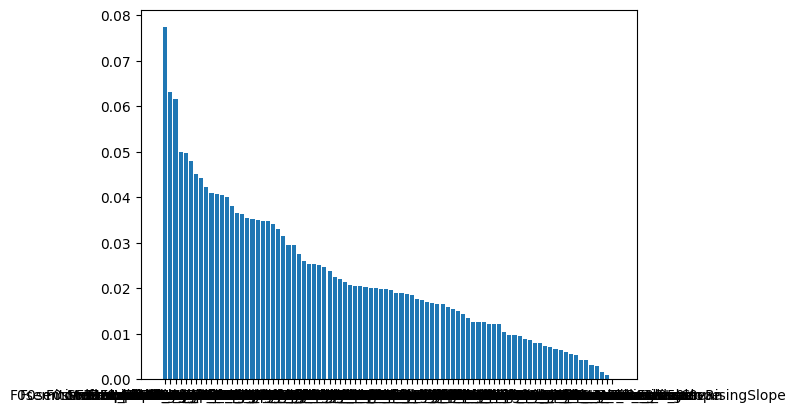

In [52]:
plt.bar(best_features, sorted(Res,reverse=True))

In [53]:
n = sorted(Res,reverse=True)

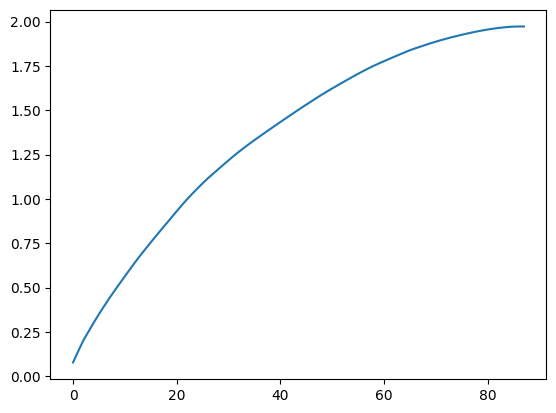

In [56]:
a = np.cumsum(n)

plt.plot(a)

In [46]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, n_features=10, n_informative=2, n_clusters_per_class=1,
    shuffle=False, random_state=42
)

In [47]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm = scaler.fit(Res)
# sorted(Res, reverse=True)
norm

ValueError: Expected 2D array, got 1D array instead:
array=[0.03483576 0.03481663 0.02935732 0.04113584 0.04987155 0.06303657
 0.02582155 0.0012953  0.02514156 0.00876064 0.01508833 0.01910178
 0.02042359 0.00312457 0.00641866 0.00797985 0.02087789 0.01258539
 0.00533429 0.01892278 0.0089223  0.01655201 0.04796259 0.07742073
 0.02363022 0.03423624 0.02055379 0.03140278 0.00602461 0.00951352
 0.00155318 0.01275704 0.00429572 0.0103935  0.01735769 0.01891437
 0.         0.01953111 0.01696023 0.01764156 0.01554565 0.01598774
 0.01215418 0.01211573 0.02951054 0.03659959 0.00408939 0.02191438
 0.02239066 0.02006259 0.03307206 0.02124733 0.00670958 0.01981661
 0.01265731 0.01654741 0.04078126 0.04000712 0.04427316 0.03549342
 0.02470877 0.012147   0.00538791 0.00965842 0.01984359 0.02540464
 0.00715801 0.01669339 0.04042383 0.03638157 0.01433073 0.02764641
 0.02019725 0.03486019 0.01850472 0.00858174 0.00302579 0.02004986
 0.00682022 0.02533719 0.00973518 0.04085544 0.04531873 0.061134
 0.04879755 0.02858384 0.03612395 0.013439  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
for i in range(len(best_features)):
    print(best_features[i])

mfcc1_sma3_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
MeanVoicedSegmentLengthSec
StddevVoicedSegmentLengthSec
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
mfcc1_sma3_amean
VoicedSegmentsPerSec
alphaRatioV_sma3nz_amean
loudnessPeaksPerSec
F0semitoneFrom27.5Hz_sma3nz_percentile50.0
F3amplitudeLogRelF0_sma3nz_amean
mfcc1V_sma3nz_amean
F3amplitudeLogRelF0_sma3nz_stddevNorm
StddevUnvoicedSegmentLength
F1amplitudeLogRelF0_sma3nz_stddevNorm
mfcc1V_sma3nz_stddevNorm
alphaRatioV_sma3nz_stddevNorm
MeanUnvoicedSegmentLength
F0semitoneFrom27.5Hz_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_amean
mfcc3V_sma3nz_stddevNorm
mfcc2_sma3_stddevNorm
F2amplitudeLogRelF0_sma3nz_amean
mfcc3_sma3_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_percentile20.0
F1amplitudeLogRelF0_sma3nz_amean
mfcc2V_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope
slopeV500-1500_sma3nz_stddevNorm
slopeUV500-1500_sma3nz_amean
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
hammarbergIndexV_sma3nz_amean
mfcc2_sma3_amean


In [37]:
import pickle

# Save the dictionary to a .pkl file
with open('rfe_cv_res.pkl', 'wb') as f:
    pickle.dump(rfe.cv_results_, f)

In [38]:

with open('rfe_cv_res.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [35]:
rfe.n_features_

51

In [37]:
rfe.support_

array([False,  True, False, False,  True,  True, False,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False, False,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [36]:
rfe.cv_results_["n_features"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88])

In [43]:
rfe.cv_results_["mean_test_score"]

array([-0.44138013, -0.11624642, -0.03982877,  0.00340859,  0.03527924,
        0.0612626 ,  0.0765724 ,  0.08637663,  0.09464394,  0.0976202 ,
        0.10024621,  0.10771391,  0.11244751,  0.11304962,  0.11636096,
        0.11767203,  0.11788883,  0.11891165,  0.12147895,  0.12210513,
        0.12232049,  0.12366973,  0.12534541,  0.12512421,  0.12427082,
        0.12509166,  0.12318506,  0.12359827,  0.12326011,  0.1238168 ,
        0.12576028,  0.12346335,  0.12581792,  0.12513828,  0.12535521,
        0.12602032,  0.12636592,  0.1261269 ,  0.12530722,  0.12653385,
        0.1267975 ,  0.12387767,  0.1269857 ,  0.12563726,  0.12568236,
        0.12513053,  0.12352363,  0.12548093,  0.12427338,  0.12396972,
        0.12692782,  0.12563017,  0.12468076,  0.123686  ,  0.12534928,
        0.126206  ,  0.12733905,  0.12488956,  0.12419654,  0.12361957,
        0.12461671,  0.1263063 ,  0.12360567,  0.12565025,  0.12429756,
        0.12645115,  0.12394007,  0.12523587,  0.12515193,  0.12

(0.0, 10.0)

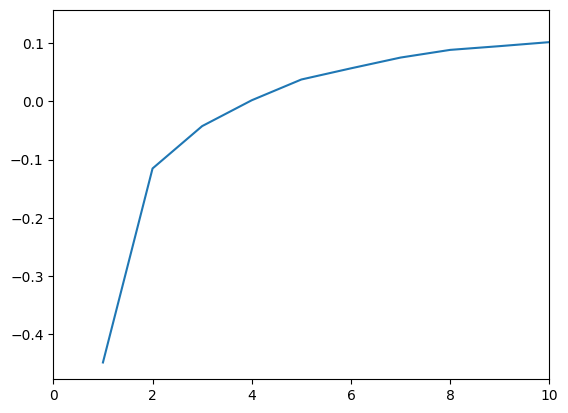

In [66]:
plt.plot(rfe.cv_results_["n_features"], rfe.cv_results_["mean_test_score"])
plt.xlim([0,10])

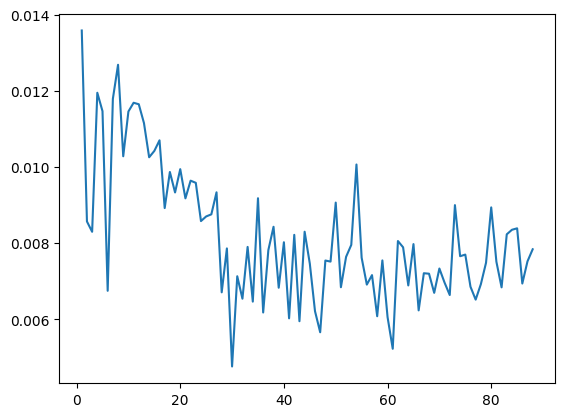

In [14]:
plt.plot(rfe.cv_results_["n_features"], rfe.cv_results_["std_test_score"])

In [41]:
rfe.cv_results_["split0_test_score"]

array([-4.74195657e-01, -1.18451734e-01, -4.91463685e-02,  2.31929503e-04,
        3.18782743e-02,  5.23717196e-02,  7.42351963e-02,  8.73866565e-02,
        9.09584682e-02,  9.64185551e-02,  1.01519664e-01,  1.03199815e-01,
        1.08489345e-01,  1.11769425e-01,  1.16471586e-01,  1.17828768e-01,
        1.14839780e-01,  1.17928529e-01,  1.10979179e-01,  1.14642285e-01,
        1.15448081e-01,  1.23530314e-01,  1.18987941e-01,  1.23342076e-01,
        1.19451213e-01,  1.17518712e-01,  1.18200061e-01,  1.21314130e-01,
        1.21464965e-01,  1.19325138e-01,  1.24851226e-01,  1.25304580e-01,
        1.20044729e-01,  1.22038460e-01,  1.25660700e-01,  1.23211596e-01,
        1.24633992e-01,  1.24975646e-01,  1.21429547e-01,  1.25940986e-01,
        1.19838571e-01,  1.24596101e-01,  1.24249409e-01,  1.23400925e-01,
        1.22193120e-01,  1.24618301e-01,  1.22663015e-01,  1.23282922e-01,
        1.24014878e-01,  1.25678741e-01,  1.31899434e-01,  1.21904705e-01,
        1.23665636e-01,  

In [42]:
rfe.cv_results_["split1_test_score"]

array([-0.45480798, -0.09720233, -0.01814443,  0.02621143,  0.04987701,
        0.06652962,  0.09108209,  0.0982691 ,  0.10904384,  0.11445734,
        0.11810646,  0.12345023,  0.12776509,  0.13000955,  0.12660003,
        0.13300817,  0.13098281,  0.13144924,  0.13207675,  0.13842994,
        0.13989325,  0.13804086,  0.13312308,  0.13957078,  0.14017838,
        0.13578352,  0.13148983,  0.13729817,  0.13824553,  0.13791389,
        0.13247549,  0.13527357,  0.13602193,  0.13486358,  0.13259121,
        0.13979286,  0.13469701,  0.13593461,  0.13100858,  0.13167654,
        0.13375996,  0.13483356,  0.13381519,  0.13338553,  0.13143245,
        0.13084435,  0.13078988,  0.12987952,  0.12601562,  0.12869054,
        0.1302639 ,  0.13412515,  0.13611996,  0.13020019,  0.12983651,
        0.13420498,  0.12856629,  0.1307063 ,  0.13267933,  0.13059165,
        0.13181475,  0.13600207,  0.13445411,  0.13096585,  0.13545133,
        0.1332417 ,  0.1336003 ,  0.13650454,  0.13301235,  0.12

In [15]:
rfe.cv_results_["mean_test_score"]

array([-0.44310448, -0.1167673 , -0.04236571,  0.00596806,  0.03385576,
        0.0592359 ,  0.07500525,  0.08680241,  0.09383613,  0.10101742,
        0.10323303,  0.10687312,  0.10978435,  0.11397482,  0.11622926,
        0.11651882,  0.11889568,  0.11857176,  0.11995418,  0.11971247,
        0.1237108 ,  0.12365064,  0.12562784,  0.12591407,  0.12350052,
        0.1248098 ,  0.12435436,  0.12320699,  0.12117064,  0.12489312,
        0.12444244,  0.12391816,  0.12643753,  0.12495227,  0.12370454,
        0.12558722,  0.12806881,  0.12628235,  0.12541091,  0.12609042,
        0.1263937 ,  0.12699974,  0.12671309,  0.12453339,  0.12457002,
        0.12560456,  0.12651321,  0.12596824,  0.12459439,  0.12536629,
        0.12490573,  0.12668812,  0.12596708,  0.12530043,  0.12593822,
        0.1253537 ,  0.12527921,  0.12565386,  0.12684164,  0.12537114,
        0.12375441,  0.12375272,  0.12528576,  0.12463616,  0.1251808 ,
        0.12324888,  0.1254296 ,  0.12313662,  0.12574103,  0.12

In [40]:
rfe.ranking_

array([36,  1, 22, 30,  1,  1, 12,  1,  1,  9, 37,  1, 11, 32, 33,  1,  1,
        1,  5,  1, 35, 14,  7,  1, 24, 10,  1, 23, 29, 20,  4,  1,  1,  1,
       28, 19,  1,  1, 17,  1, 16,  1,  2,  1, 27,  1,  1,  1,  1,  1, 38,
       31,  1,  1,  1, 18, 34, 15,  1,  1, 21, 13,  1,  1,  1,  1,  8,  1,
        1,  1,  1,  1,  1,  3,  1,  6, 25,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 26])

In [17]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [61]:
from operator import itemgetter
features = X_train.columns.to_list()
best_features_rfe = []
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    if x == 1:
        print(y)
        best_features_rfe.append(y)

F0semitoneFrom27.5Hz_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
loudness_sma3_stddevNorm
loudness_sma3_pctlrange0-2
loudness_sma3_meanRisingSlope
loudness_sma3_stddevRisingSlope
loudness_sma3_stddevFallingSlope
mfcc1_sma3_stddevNorm
mfcc3_sma3_amean
jitterLocal_sma3nz_stddevNorm
shimmerLocaldB_sma3nz_amean
shimmerLocaldB_sma3nz_stddevNorm
logRelF0-H1-H2_sma3nz_amean
logRelF0-H1-H2_sma3nz_stddevNorm
logRelF0-H1-A3_sma3nz_stddevNorm
F1frequency_sma3nz_stddevNorm
F1bandwidth_sma3nz_stddevNorm
F1amplitudeLogRelF0_sma3nz_stddevNorm
F2frequency_sma3nz_amean
F2frequency_sma3nz_stddevNorm
F2bandwidth_sma3nz_amean
F2bandwidth_sma3nz_stddevNorm
F3frequency_sma3nz_amean
F3frequency_sma3nz_stddevNorm
F3bandwidth_sma3nz_amean
alphaRatioV_sma3nz_amean
alphaRatioV_sma3nz_stddevNorm
slopeV0-500_sma3nz_amean
slopeV0-500_sma3nz_stddevNorm
slopeV500-1500_sm

In [82]:
best_features[:10]

['mfcc1_sma3_stddevNorm',
 'MeanVoicedSegmentLengthSec',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'StddevVoicedSegmentLengthSec',
 'mfcc1_sma3_amean',
 'alphaRatioV_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'mfcc1V_sma3nz_amean']

In [83]:
best_features_rfe[:10]

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_n, Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [29]:
from datetime import datetime  
name = datetime.now().strftime("model/SER_DEMoS_41feat_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=15,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


model = get_cnn((X_train.shape[1:]))
model.summary()

history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 4095)           │       171,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2048)           │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,358,398 (43.33 MB)

 Trainable params: 11,358,398 (43.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1557 - loss: 24.8528
Epoch 1: val_loss improved from inf to 2.21370, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.1557 - loss: 24.7031 - val_accuracy: 0.1094 - val_loss: 2.2137
Epoch 2/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1406 - loss: 2.2304
Epoch 2: val_loss improved from 2.21370 to 2.02475, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1407 - loss: 2.2389 - val_accuracy: 0.1489 - val_loss: 2.0247
Epoch 3/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1541 - loss: 2.0778
Epoch 3: val_loss improved from 2.02475 to 2.02292, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.1541 - loss: 2.0787 - val_accuracy: 0.1523 - val_loss: 2.0229
Epoch 4/1000
218/219 ━━━━━━━━━

In [25]:
from keras import layers, models
def get_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    encoder = layers.LSTM(256)(inputs)
    drop = layers.Dropout(0.3)(encoder)
    hidden1 = layers.Dense(128, activation='relu')(drop)

    hidden2 = layers.Dense(64, activation='relu')(hidden1)
    hidden = layers.Dense(32, activation='relu')(hidden2)
    outputs = layers.Dense(8, activation='softmax')(hidden)
    
    model = models.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

    return model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(X_n,axis=2), Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [ ]:
LSTM_model = get_model((X_train.shape[1:]))
LSTM_model.summary()


from datetime import datetime  
name = datetime.now().strftime("model/lstm_41feat_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,688 (1.17 MB)

 Trainable params: 307,688 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1461 - loss: 2.0392
Epoch 1: val_loss improved from inf to 2.00979, saving model to model/lstm_28_feat_05_11_2024_11_45_26.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1463 - loss: 2.0391 - val_accuracy: 0.1569 - val_loss: 2.0098
Epoch 2/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1668 - loss: 2.0234
Epoch 2: val_loss did not improve from 2.00979
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1669 - loss: 2.0233 - val_accuracy: 0.1690 - val_loss: 2.0207
Epoch 3/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1786 - loss: 2.0128
Epoch 3: val_loss improved from 2.00979 to 1.99227, saving model to model/lstm_28_feat_05_11_2024_11_45_26.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1785 - loss: 2.0128 - val_accuracy: 0.1924 - val_loss: 1.9923
Epoch 4/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1739 - loss: 2.0148
Epoch 4: val_loss imp

(9696, 41)

In [42]:
from datetime import datetime  
name = datetime.now().strftime("model/SER_DEMoS_function_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=15,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]



X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(X_n,axis=2), Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)


model = get_model((X_train.shape[1:]))
model.summary()

history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 39, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 18, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,016 (558.66 KB)

 Trainable params: 143,016 (558.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1532 - loss: 4.1102
Epoch 1: val_loss improved from inf to 2.05900, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1532 - loss: 4.1033 - val_accuracy: 0.1569 - val_loss: 2.0590
Epoch 2/1000
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1567 - loss: 2.0613
Epoch 2: val_loss improved from 2.05900 to 2.03955, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1570 - loss: 2.0610 - val_accuracy: 0.1672 - val_loss: 2.0395
Epoch 3/1000
208/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1713 - loss: 2.0411
Epoch 3: val_loss improved from 2.03955 to 2.02684, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1715 - loss: 2.0409 - val_accuracy: 0.1672 - val_loss: 2.0268
Epoch 4/1000
210/219 ━━━━━━━━━━━